In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = 500

### Загрузим датасет с машинами. Цель - верно восстанавливать для каждой из них цену продажи!

In [3]:
data = pd.read_csv('autos.csv')

data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [4]:
### Колонка с тергетом - "selling price"

X = data.drop("selling_price", axis=1)
y = data["selling_price"]

### Будем замерять MSLE!
### Поэтому прологарифмируем таргет
### А после оптимизируем MSE

y = y.apply(np.log1p)

In [5]:
### Разделим выборку на трейн и тест!

from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

__Задание__ 

Реализуйте свой MeanTargetEncoder с добавленем некоторого шума!

Однажды в лекционном материале, обсуждая счетчики, мы говорили с вами о том, что из-за них модели могут переобучаться. Один из способов бороться с этим - валидировать расчеты среднего таргета (стратегия отложенной выборки / расчеты на кросс-валидации). Но есть еще проще!

Можно просто к значению счетчика добавить случайный шум (зашумить данные)!

Напомним, что рассчитываться новые признаки должны по такой формуле:

$$
g_j = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}{l} + C * \epsilon
$$


Пусть шум будет случайной величиной из нормального стандартного распределения, то есть $\epsilon \sim N(0, 1) $, а $ C = 0.006$.

Создавай свой класс-трансформер, наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`. Трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. 
Ваш трансформер должен принимать при инициализации список из категориальных признаков и список из числовых признаков. 

Если для какого-то признака в тестовой выборке отсутствует значение, трансформер должен поставить там 0.

На выходе должен получиться датасет того же размера с измененными категориальными признаками

In [6]:
object_cols = ['name', 'year', 'fuel', 'seller_type', 'transmission', 'owner']
num_cols = ['km_driven']

X.head()

,name,year,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,141000,Diesel,Individual,Manual,Second Owner


In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanTargetEncoderNoise(BaseEstimator, TransformerMixin):
    
    def __init__(self, categorical, numeric):
        
        self.categorical = categorical
        self.numeric = numeric
        self.dict_means = {}
    
    def fit(self, X, y):
        df = pd.DataFrame(X)

        for col in self.categorical:
            means_of_col = df.groupby(col)['km_driven'].mean()
            self.dict_means[col] = means_of_col
                
        ### Your code is here

        return self
        
    def transform(self, df):
        temp = df.copy()
        for col in self.categorical:
            temp[col] = temp[col].map(self.dict_means[col])
            temp[col] = temp[col]  +  0.006 * np.random.randn()
            temp[col] = temp[col].fillna(0)
       
        ### Your code is here
        
        return temp

In [8]:
### Проверка работы трансформера

np.random.seed(1)
transformer = MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)

transformer.fit(X_train, y_train)

train = transformer.transform(X_train)
test = transformer.transform(X_test)

train.head()


,name,year,km_driven,fuel,seller_type,transmission,owner
3294,30500.009746,26527.945994,50000,79747.333692,71427.468178,48724.173171,55580.143175
2290,70000.009746,88089.412259,70000,52544.985810,71427.468178,48724.173171,55580.143175
874,40584.055201,40470.928395,50000,52544.985810,71427.468178,68317.139777,55580.143175
1907,62442.009746,59106.500973,92198,52544.985810,51788.586483,68317.139777,82059.106146
3244,41746.719423,73158.841266,3240,52544.985810,71427.468178,68317.139777,82059.106146


Обучите несколько деревьев, перебирая максимальную глубину алгоритма из списка `max_depth_list`, а остальные параметры оставьте дефолтными. Выведите лучшее значение гиперпараметра. Постройте график зависимости MSLE на тестовой выборке от значения гиперпараметра. Воспользуйтесь `Pipeline` без `GridSearch`. Проделайте то же самое с `min_samples_split`, `min_impurity_decrease`, `max_leaf_nodes`. (по 2б на каждый параметр)

In [9]:
max_depth_list = [3, 5, 8, 12]
min_samples_split_list = [10, 50, 100, 500]
min_impurity_decrease_list = [0, 0.1, 0.15, 0.2]
max_leaf_nodes_list = [100, 200, 500]

{'tree__max_depth': 3}
{'tree__max_depth': 5}
{'tree__max_depth': 8}
{'tree__max_depth': 12}
MSLE : 0.802
{'tree__max_depth': 8.0, 'tree__min_samples_split': 10}
{'tree__max_depth': 8.0, 'tree__min_samples_split': 50}
{'tree__max_depth': 8.0, 'tree__min_samples_split': 100}
{'tree__max_depth': 8.0, 'tree__min_samples_split': 500}
MSLE : 0.902
{'tree__max_depth': 8.0, 'tree__min_samples_split': 10, 'tree__min_impurity_decrease': 0}
{'tree__max_depth': 8.0, 'tree__min_samples_split': 10, 'tree__min_impurity_decrease': 0.1}
{'tree__max_depth': 8.0, 'tree__min_samples_split': 10, 'tree__min_impurity_decrease': 0.15}
{'tree__max_depth': 8.0, 'tree__min_samples_split': 10, 'tree__min_impurity_decrease': 0.2}
MSLE : 0.829
{'tree__max_depth': 8.0, 'tree__min_samples_split': 10, 'tree__min_impurity_decrease': 0.1, 'tree__max_leaf_nodes': 100}
{'tree__max_depth': 8.0, 'tree__min_samples_split': 10, 'tree__min_impurity_decrease': 0.1, 'tree__max_leaf_nodes': 200}
{'tree__max_depth': 8.0, 'tree__m

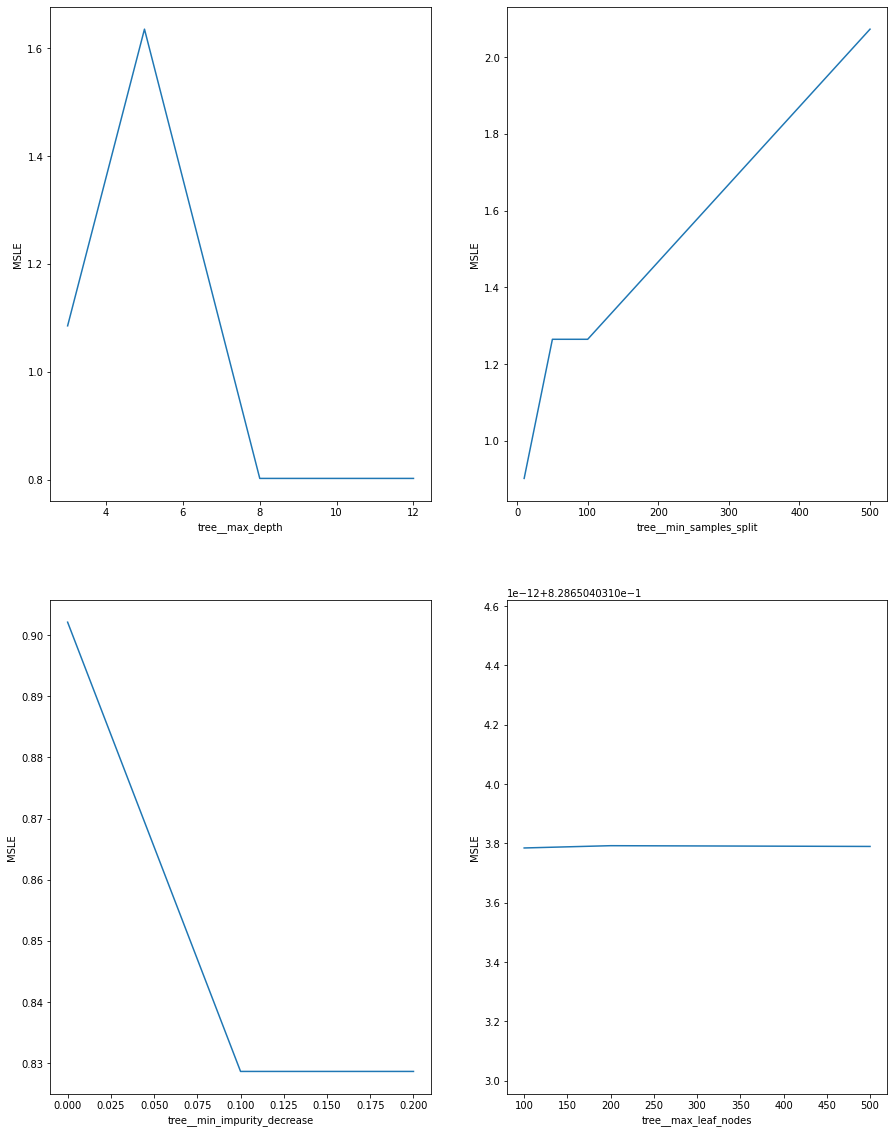

In [25]:
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

np.random.seed(1)

### Your code is here
param_dict = {'tree__max_depth': max_depth_list, 
              'tree__min_samples_split': min_samples_split_list, 
              'tree__min_impurity_decrease': min_impurity_decrease_list, 
              'tree__max_leaf_nodes': max_leaf_nodes_list}

best_params = {}

fig = plt.figure()
fig.set_size_inches(15,20)

num = 1
for param, param_list in param_dict.items():
    fig.add_subplot(2,2,num)
    num += 1
    array = []
    for i in param_list:
        tree_pipe = Pipeline([('trasformer', MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
                              ('scaler',StandardScaler()),
                              ('tree',DecisionTreeRegressor())])
        
        best_params[param] = i        
        tree_pipe.set_params(**best_params)
        print(best_params)
        
        tree_pipe.fit(X_train,y_train)
        y_pred = tree_pipe.predict(test)
        mse = mean_squared_error(y_test, y_pred)
        array.append([i,mse])
    
    array = np.array(array)
    best_value = array[np.argmin(array[:,1]),0]
    best_params[param] = best_value if param != 'tree__min_samples_split' else int(best_value)
    
    sns.lineplot(x=array[:,0], y=array[:,1])
    plt.xlabel(f'{param}')
    plt.ylabel('MSLE')
    print('MSLE :', np.min(array[:,1]).round(3))
        

Подберите лучшую комбинацию параметров, используя `GridSearchCV` и набор массивов значений параметров из предыдущего задания. Для лучшей комбинации посчитайте MSLE на тестовой выборке. Получились ли лучшие параметры такими же, как если бы вы подбирали их по-отдельности при остальных гиперпараметрах по умолчанию (предыдущее задание)? (2б)

In [26]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "tree__max_depth": [3, 5, 8, 12],
    "tree__min_samples_split": [10, 50, 100, 500],
    "tree__min_impurity_decrease": [0, 0.1, 0.15, 0.2],
    "tree__max_leaf_nodes": [100, 200, 500]
}
np.random.seed(1)

tree = Pipeline([('tree',DecisionTreeRegressor())])

grid_tree = GridSearchCV(tree,param_grid, scoring='neg_mean_squared_log_error')
grid_tree.fit(train, y_train)

y_pred = grid_tree.predict(test)
mse = mean_squared_error(y_test, y_pred)

### Your code is here

grid_tree.best_params_



{'tree__max_depth': 12,
 'tree__max_leaf_nodes': 500,
 'tree__min_impurity_decrease': 0,
 'tree__min_samples_split': 50}

In [27]:
mse.round(3)

0.308